In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from analysis_scripts import plot_3d_scan_data_2screens, plot_3d_scan_data_2screens_contour, create_clipped_dset, run_3d_scan_2screens

In [3]:
# load data
data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_scan'
#data_dir = '/Users/jpga/AWA_DATA/01_16_6D_PSR/reconstruction_scan'
save_dir =  "."#'/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_results/scan_5'
clipped_dset = torch.load(os.path.join(save_dir, 'dset_01_18_scan_5_clipped.pt'))

In [4]:
clipped_dset.params

tensor([[[[-2.9472e+00,  0.0000e+00,  2.2200e-16],
          [-2.9472e+00,  0.0000e+00,  1.1508e+00]],

         [[-2.9472e+00,  3.7000e+06,  2.2200e-16],
          [-2.9472e+00,  3.7000e+06,  1.1508e+00]]],


        [[[-2.2104e+00,  0.0000e+00,  2.2200e-16],
          [-2.2104e+00,  0.0000e+00,  1.1508e+00]],

         [[-2.2104e+00,  3.7000e+06,  2.2200e-16],
          [-2.2104e+00,  3.7000e+06,  1.1508e+00]]],


        [[[-1.4736e+00,  0.0000e+00,  2.2200e-16],
          [-1.4736e+00,  0.0000e+00,  1.1508e+00]],

         [[-1.4736e+00,  3.7000e+06,  2.2200e-16],
          [-1.4736e+00,  3.7000e+06,  1.1508e+00]]],


        [[[-7.3680e-01,  0.0000e+00,  2.2200e-16],
          [-7.3680e-01,  0.0000e+00,  1.1508e+00]],

         [[-7.3680e-01,  3.7000e+06,  2.2200e-16],
          [-7.3680e-01,  3.7000e+06,  1.1508e+00]]],


        [[[ 0.0000e+00,  0.0000e+00,  2.2200e-16],
          [ 0.0000e+00,  0.0000e+00,  1.1508e+00]],

         [[ 0.0000e+00,  3.7000e+06,  2.2200e-16],
     

In [3]:
clipped_dset.images.shape

torch.Size([9, 2, 2, 3, 300, 300])

In [4]:
# max intensity
vmax1 = clipped_dset.images[4,0,0].max()
print(vmax1)
vmax2 = clipped_dset.images[4,0,1].max()
print(vmax2)

tensor(0.0022, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)


(<Figure size 2000x1000 with 50 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

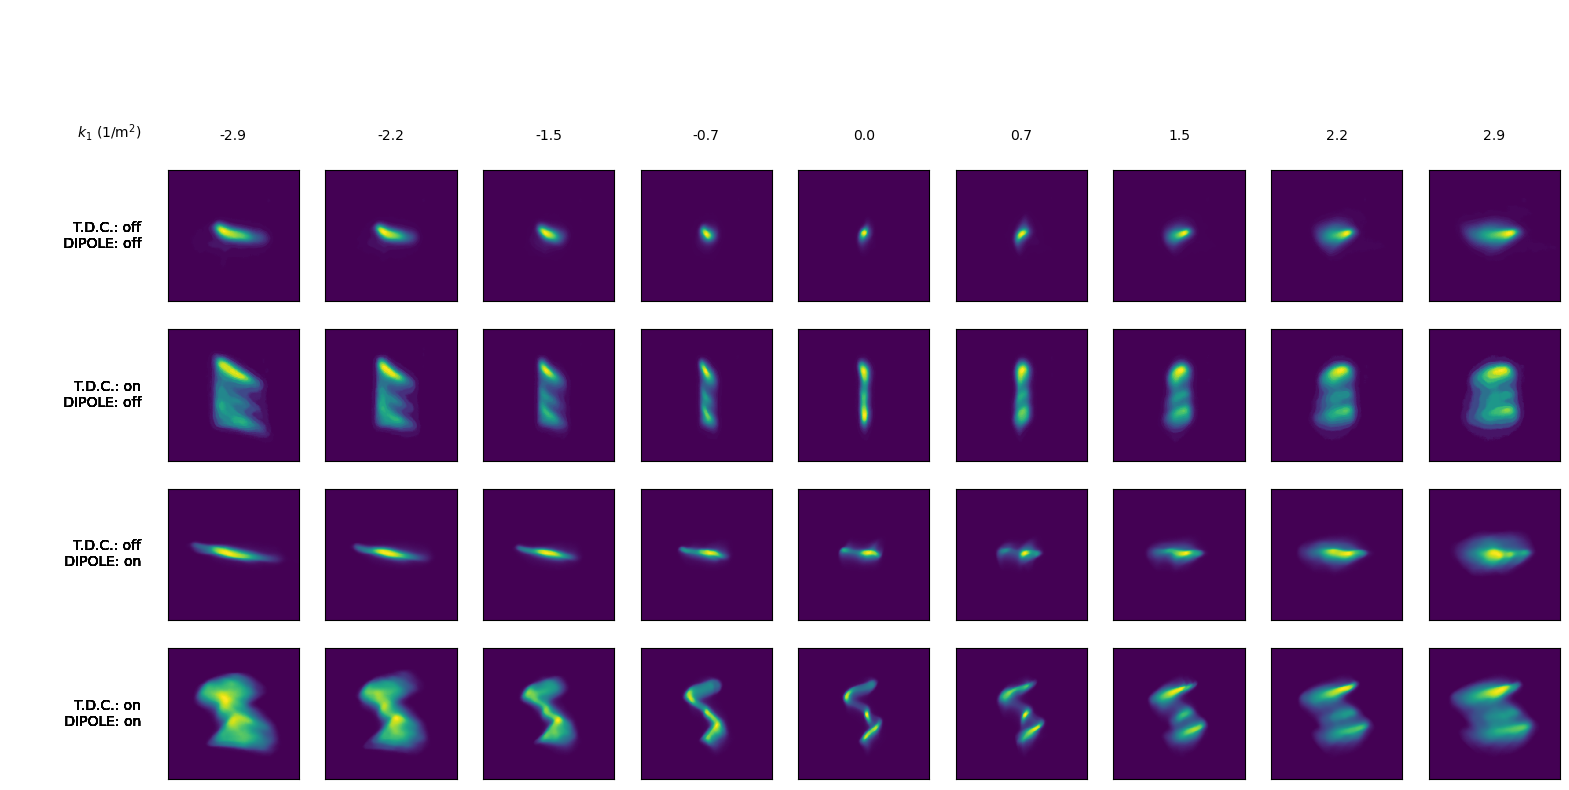

In [5]:
plot_3d_scan_data_2screens(clipped_dset)

In [6]:
train_dset, test_dset = split_2screen_dset(clipped_dset)

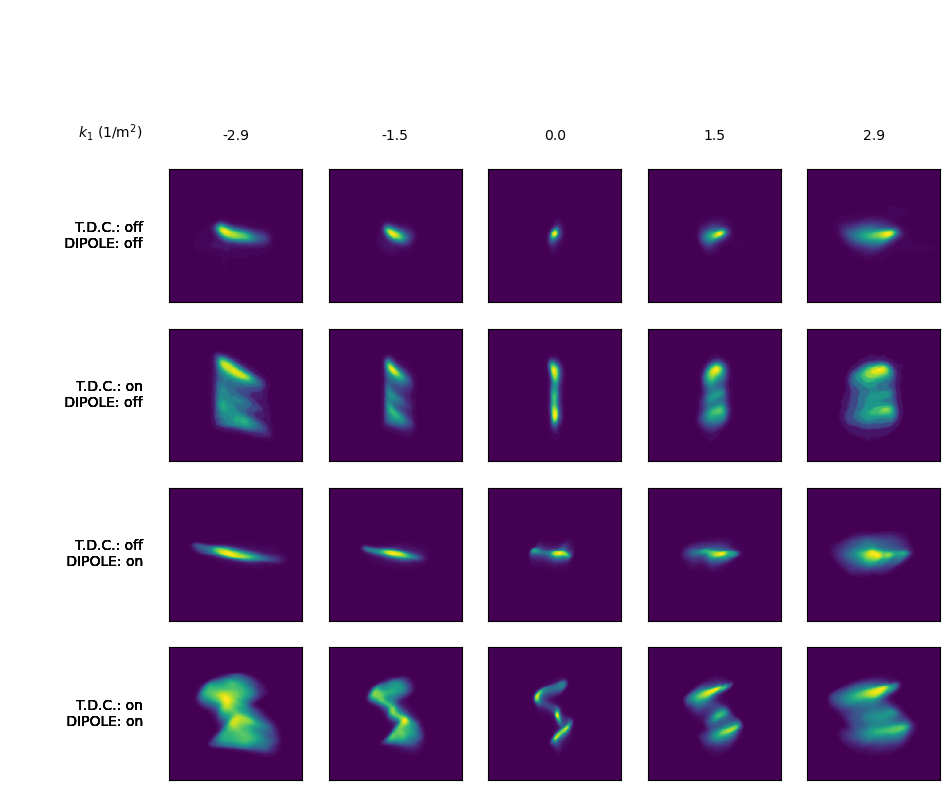

In [7]:
fig, ax = plot_3d_scan_data_2screens(train_dset)
fig.savefig("training_data.png",dpi=300)

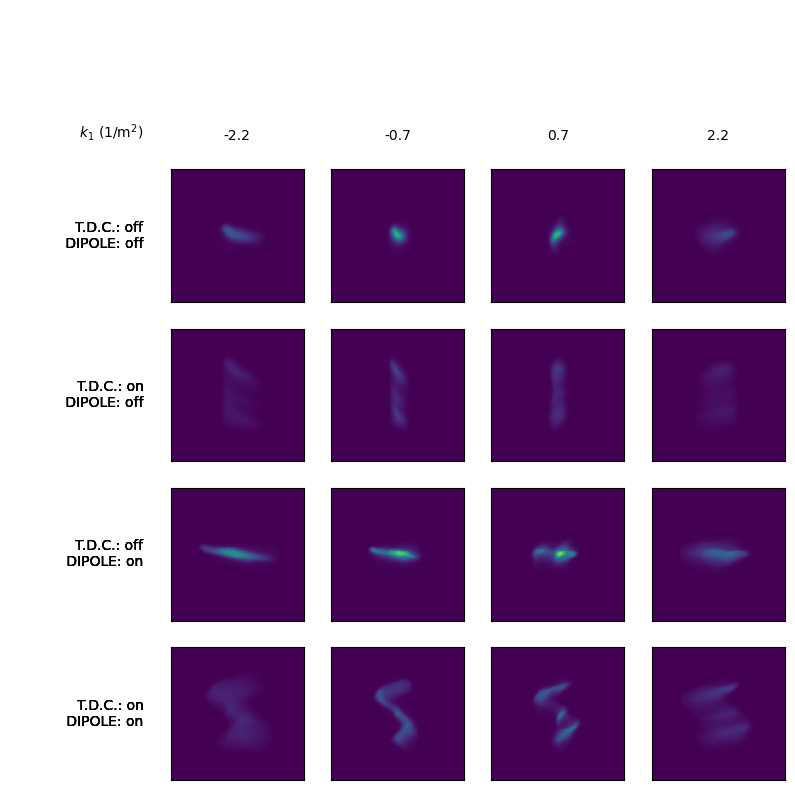

In [8]:
plot_3d_scan_data_2screens(test_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [9]:
from bmadx import Particle
def numpy_to_torch_particles(particle: Particle):
    '''Returns Particle with torch tensors from particles with numpy arrays.'''
    return Particle(
        x = torch.tensor(particle.x),
        px = torch.tensor(particle.px),
        y = torch.tensor(particle.y),
        py = torch.tensor(particle.py),
        z = torch.tensor(particle.z),
        pz = torch.tensor(particle.pz),
        s = torch.tensor(particle.s),
        p0c = torch.tensor(particle.p0c),
        mc2 = torch.tensor(particle.mc2)
    )
#pred_beam = numpy_to_torch_particles(torch.load('pred_beam_01_18_scan_5_centered_clipped.pt'))

pred_beam = numpy_to_torch_particles(torch.load(os.path.join(save_dir,'dist_3000.pt')))

/tmp/ipykernel_38686/3377160210.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(particle.x),
/tmp/ipykernel_38686/3377160210.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  px = torch.tensor(particle.px),
/tmp/ipykernel_38686/3377160210.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(particle.y),
/tmp/ipykernel_38686/3377160210.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

In [10]:
test_dset.params.shape

torch.Size([4, 2, 2, 3])

In [11]:
# diagnostic beamline:
p0c = 43.3e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)
width = 300
size_0 = 30.22*1e-3*width/700
size_1 = 26.96*1e-3*width/700
screen0 = create_screen(size_0, width)
screen1 = create_screen(size_1, width)

In [12]:
pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=test_dset.params,
    ids=scan_ids
)

torch.Size([4, 2, 2, 3])
torch.Size([4, 2, 3, 1])


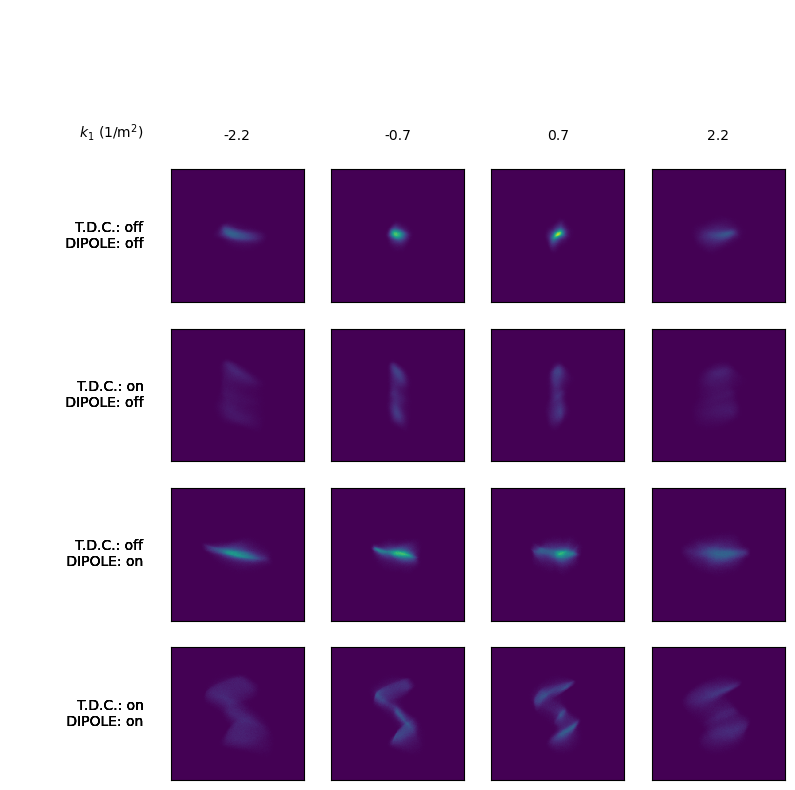

In [13]:
plot_3d_scan_data_2screens(pred_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

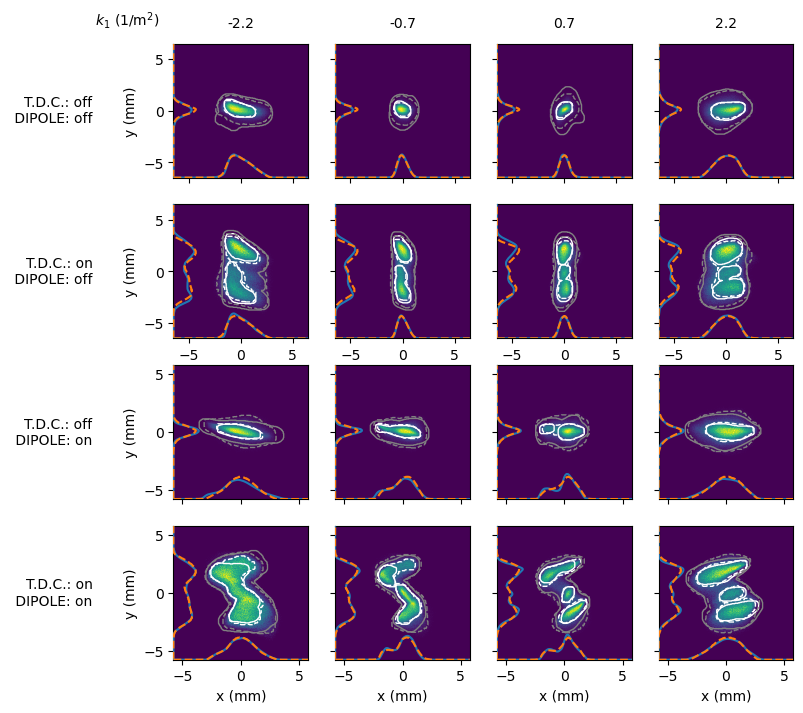

In [19]:
fig,ax = plot_3d_scan_data_2screens_contour(pred_dset, test_dset, screen_0_len = size_0, screen_1_len=size_1)
fig.savefig("exp_results_3000.svg")

In [15]:
complete_pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=clipped_dset.params,
    ids=scan_ids
)

torch.Size([9, 2, 2, 3])
torch.Size([9, 2, 3, 1])


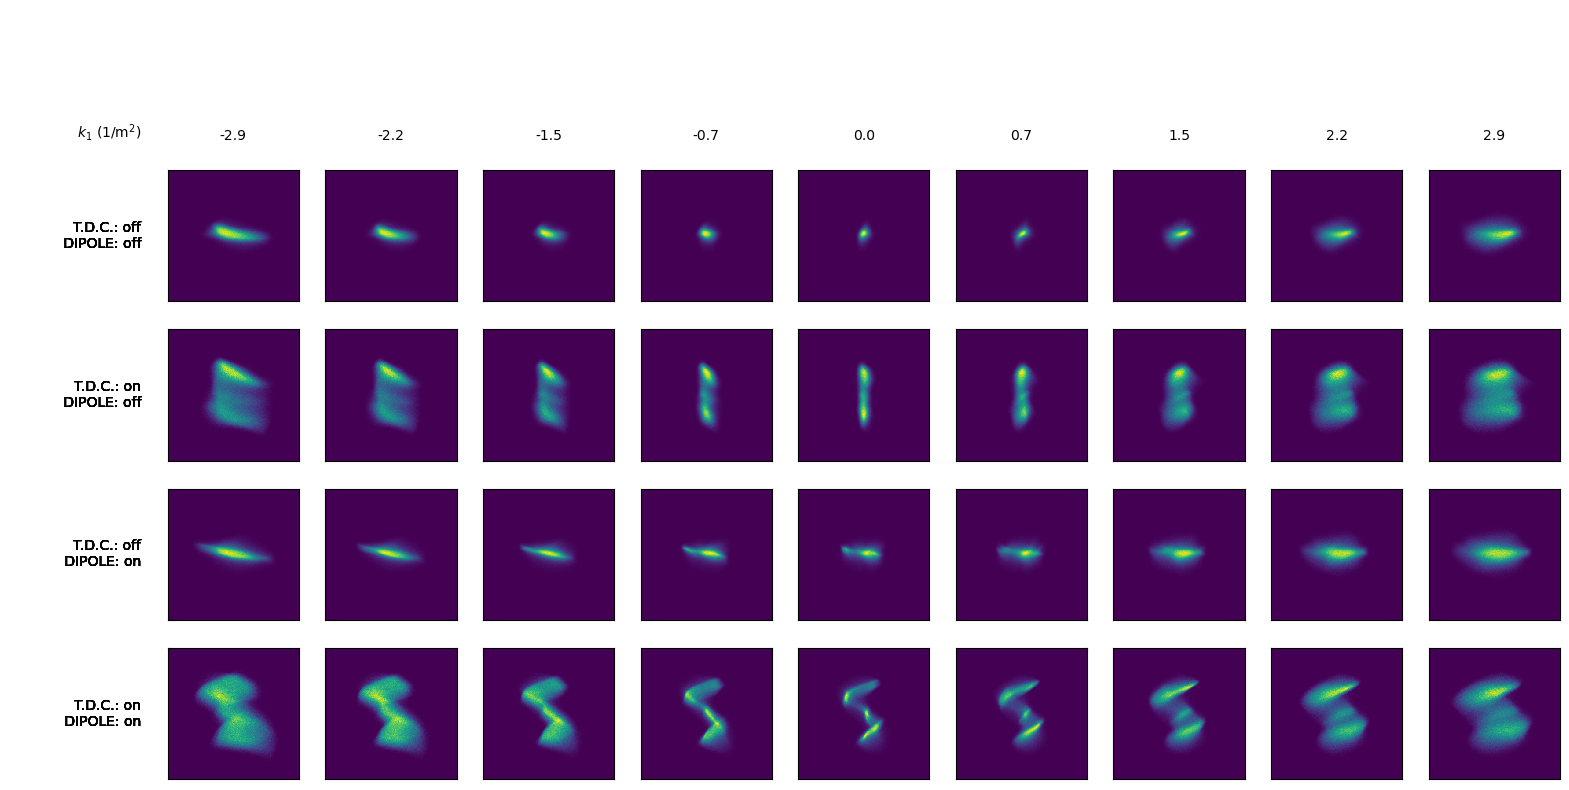

In [16]:
plot_3d_scan_data_2screens(complete_pred_dset)
plt.show()

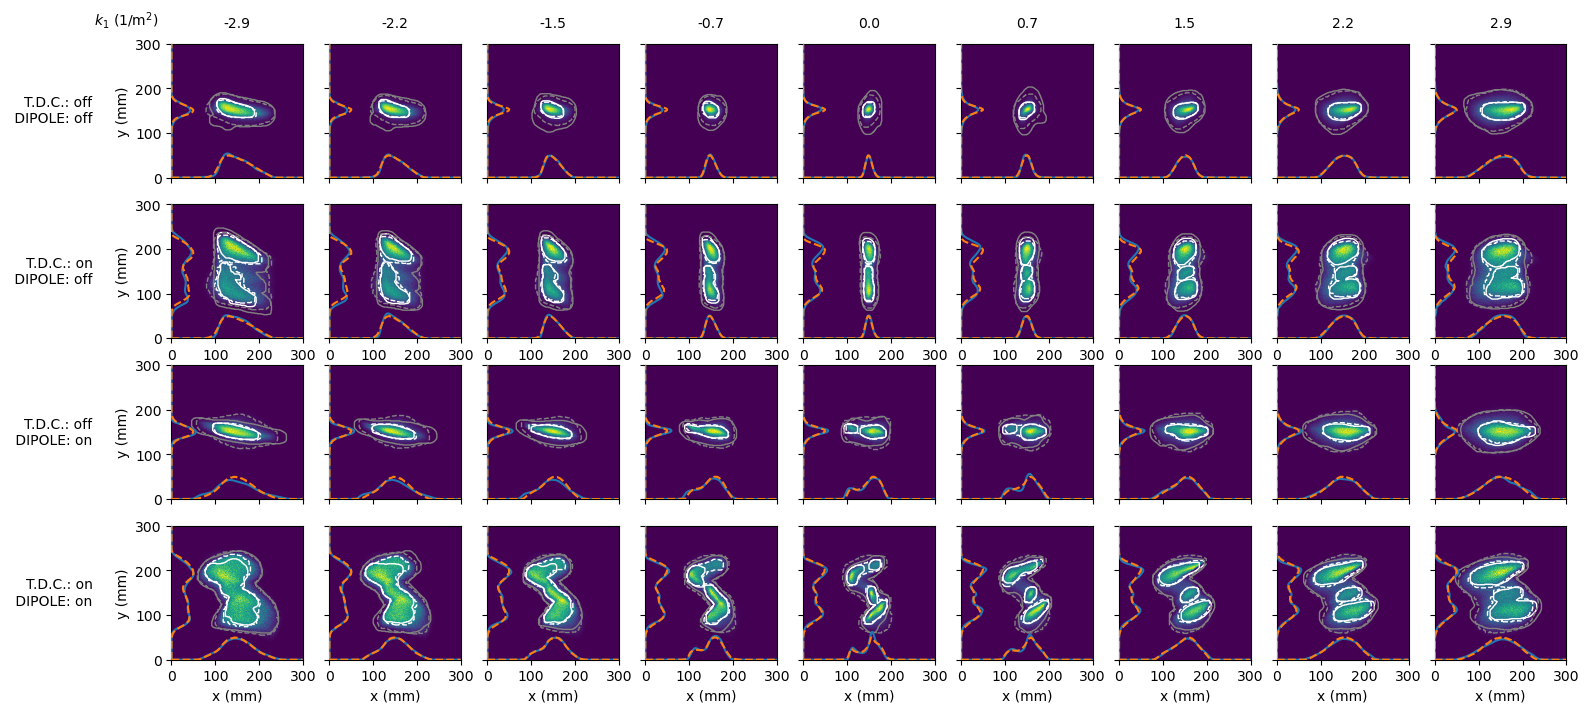

In [17]:
plot_3d_scan_data_2screens_contour(complete_pred_dset, clipped_dset)
plt.show()

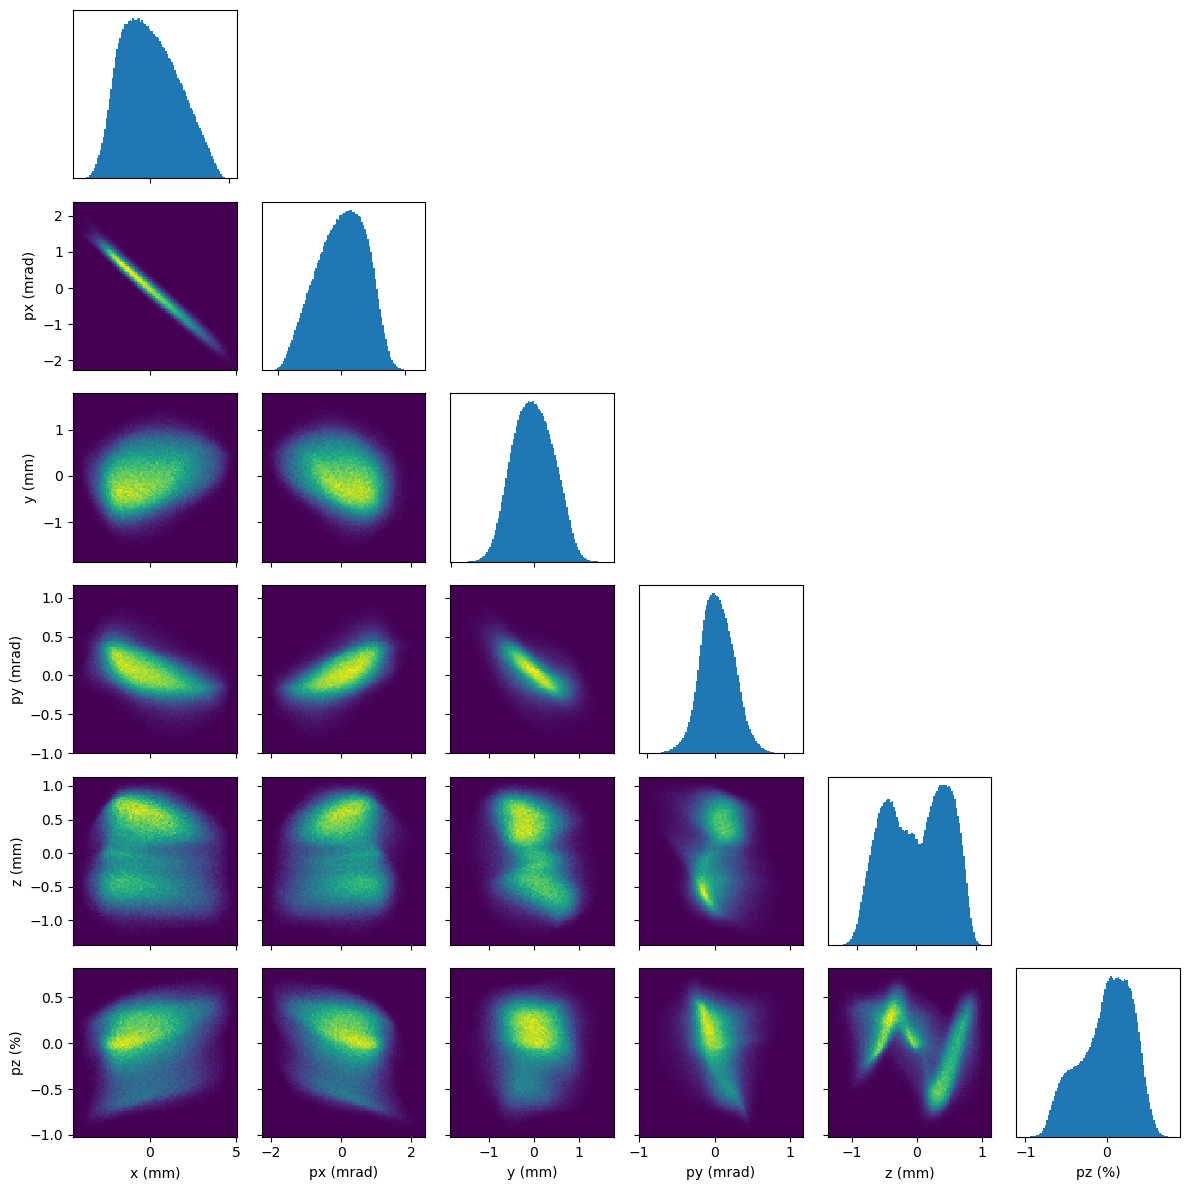

In [18]:
fig, ax = plot_projections(pred_beam,
                           #custom_lims = lims,
                           bins = 100
                           )
fig.savefig("reconstructed_distribution.png", dpi=300)
plt.show()